<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [373]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

df = pd.read_csv('./nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


In [374]:
# SEED
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(1314520)

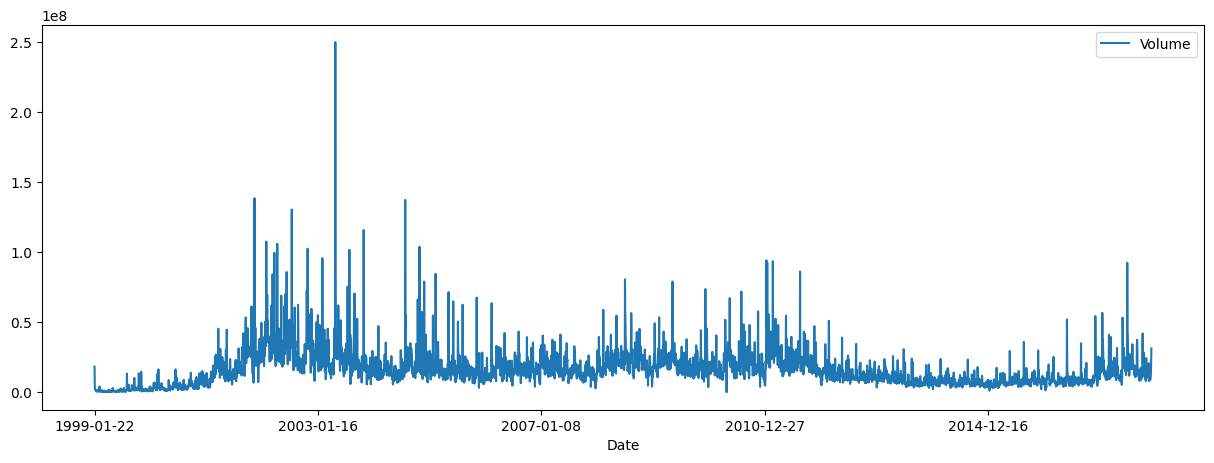

In [375]:
plot = df.plot('Date', 'Volume', figsize=(15, 5))

In [376]:
df[["High", "Low", "Open", "Close", "Volume"]].corr()

,High,Low,Open,Close,Volume
High,1.000000,0.999770,0.999862,0.999838,-0.004774
Low,0.999770,1.000000,0.999804,0.999863,-0.011785
Open,0.999862,0.999804,1.000000,0.999658,-0.007865
Close,0.999838,0.999863,0.999658,1.000000,-0.008339
Volume,-0.004774,-0.011785,-0.007865,-0.008339,1.000000


In [377]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [379]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [380]:
df = df.dropna()

In [381]:
df.shape

(4733, 7)

In [382]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [383]:
def create_sequences(input_data, output_data, window_size, step):
    
    print(f"Input Data Size: {input_data.shape}, Output Data Size: {output_data.shape}, Window Size: {window_size}, Step: {step}")
    
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [384]:
# Select features
features = df[['Open', 'High', 'Low', "Close", 'Volume']]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=5, step=5)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

train_mean = x_train.mean(axis=(0, 1), keepdims=True)
train_std = x_train.std(axis=(0, 1), keepdims=True)

x_train = (x_train - train_mean) / (train_std + 1e-8)
x_val = (x_val - train_mean) / (train_std + 1e-8)
x_test = (x_test - train_mean) / (train_std + 1e-8)

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Input Data Size: (4733, 5), Output Data Size: (4733,), Window Size: 5, Step: 5
Shape of data X: (946, 5, 5)
Shape of data y: (946,)
Shape of data x_train: (681, 5, 5)
Shape of data y_train: (681,)
Shape of data x_val: (171, 5, 5)
Shape of data y_val: (171,)
Shape of data x_test: (94, 5, 5)
Shape of data y_test: (94,)
Number of samples in training and validation are 681 and 171.


## B. Defining Neural Networks

In [385]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [386]:
# Check your GPU status.
!nvidia-smi

Thu May  1 15:11:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   31C    P8             13W /  130W |    1934MiB /   8192MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [387]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 100

model = LSTMModel(input_dim=5, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')
best_train_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Train loss: {best_train_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(5, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  3%|▎         | 3/100 [00:00<00:13,  6.96it/s]

Epoch 1/100, Train loss: 1055.1709, Val loss: 901.9128, Best Train loss: 1055.1709, Best Val loss: 901.9128
Epoch 2/100, Train loss: 800.9082, Val loss: 798.7786, Best Train loss: 800.9082, Best Val loss: 798.7786
Epoch 3/100, Train loss: 683.8693, Val loss: 665.5354, Best Train loss: 683.8693, Best Val loss: 665.5354


  5%|▌         | 5/100 [00:00<00:11,  8.37it/s]

Epoch 4/100, Train loss: 581.3714, Val loss: 565.1912, Best Train loss: 581.3714, Best Val loss: 565.1912
Epoch 5/100, Train loss: 498.5299, Val loss: 483.7180, Best Train loss: 498.5299, Best Val loss: 483.7180
Epoch 6/100, Train loss: 429.9673, Val loss: 408.7504, Best Train loss: 429.9673, Best Val loss: 408.7504


  9%|▉         | 9/100 [00:01<00:09,  9.84it/s]

Epoch 7/100, Train loss: 376.0479, Val loss: 348.9372, Best Train loss: 376.0479, Best Val loss: 348.9372
Epoch 8/100, Train loss: 322.1239, Val loss: 301.0237, Best Train loss: 322.1239, Best Val loss: 301.0237
Epoch 9/100, Train loss: 347.3171, Val loss: 260.1950, Best Train loss: 347.3171, Best Val loss: 260.1950


 11%|█         | 11/100 [00:01<00:08, 10.13it/s]

Epoch 10/100, Train loss: 252.5397, Val loss: 219.4382, Best Train loss: 252.5397, Best Val loss: 219.4382
Epoch 11/100, Train loss: 219.1555, Val loss: 191.5170, Best Train loss: 219.1555, Best Val loss: 191.5170
Epoch 12/100, Train loss: 202.3850, Val loss: 185.2921, Best Train loss: 202.3850, Best Val loss: 185.2921


 15%|█▌        | 15/100 [00:01<00:08, 10.41it/s]

Epoch 13/100, Train loss: 178.0577, Val loss: 152.0235, Best Train loss: 178.0577, Best Val loss: 152.0235
Epoch 14/100, Train loss: 155.6908, Val loss: 134.5397, Best Train loss: 155.6908, Best Val loss: 134.5397
Epoch 15/100, Train loss: 153.2967, Val loss: 119.8341, Best Train loss: 153.2967, Best Val loss: 119.8341


 17%|█▋        | 17/100 [00:01<00:07, 10.78it/s]

Epoch 16/100, Train loss: 149.4318, Val loss: 107.3561, Best Train loss: 149.4318, Best Val loss: 107.3561
Epoch 17/100, Train loss: 108.2951, Val loss: 101.3300, Best Train loss: 108.2951, Best Val loss: 101.3300
Epoch 18/100, Train loss: 99.6968, Val loss: 89.3841, Best Train loss: 99.6968, Best Val loss: 89.3841


 21%|██        | 21/100 [00:02<00:07, 10.91it/s]

Epoch 19/100, Train loss: 96.1209, Val loss: 80.7073, Best Train loss: 96.1209, Best Val loss: 80.7073
Epoch 20/100, Train loss: 78.5761, Val loss: 76.2154, Best Train loss: 78.5761, Best Val loss: 76.2154
Epoch 21/100, Train loss: 71.7046, Val loss: 65.6388, Best Train loss: 71.7046, Best Val loss: 65.6388


 23%|██▎       | 23/100 [00:02<00:06, 11.32it/s]

Epoch 22/100, Train loss: 73.1549, Val loss: 66.5923, Best Train loss: 71.7046, Best Val loss: 65.6388
Epoch 23/100, Train loss: 64.3886, Val loss: 59.5048, Best Train loss: 64.3886, Best Val loss: 59.5048
Epoch 24/100, Train loss: 54.5076, Val loss: 50.7749, Best Train loss: 54.5076, Best Val loss: 50.7749


 27%|██▋       | 27/100 [00:02<00:06, 11.33it/s]

Epoch 25/100, Train loss: 48.1376, Val loss: 46.6751, Best Train loss: 48.1376, Best Val loss: 46.6751
Epoch 26/100, Train loss: 46.5098, Val loss: 46.5281, Best Train loss: 46.5098, Best Val loss: 46.5281
Epoch 27/100, Train loss: 41.1011, Val loss: 43.0517, Best Train loss: 41.1011, Best Val loss: 43.0517


 29%|██▉       | 29/100 [00:02<00:06, 11.34it/s]

Epoch 28/100, Train loss: 37.6592, Val loss: 40.1332, Best Train loss: 37.6592, Best Val loss: 40.1332
Epoch 29/100, Train loss: 41.1795, Val loss: 37.9236, Best Train loss: 41.1795, Best Val loss: 37.9236
Epoch 30/100, Train loss: 33.1059, Val loss: 34.6866, Best Train loss: 33.1059, Best Val loss: 34.6866


 33%|███▎      | 33/100 [00:03<00:05, 11.57it/s]

Epoch 31/100, Train loss: 29.3594, Val loss: 32.3999, Best Train loss: 29.3594, Best Val loss: 32.3999
Epoch 32/100, Train loss: 26.6525, Val loss: 27.8835, Best Train loss: 26.6525, Best Val loss: 27.8835
Epoch 33/100, Train loss: 30.7300, Val loss: 31.9381, Best Train loss: 26.6525, Best Val loss: 27.8835


 35%|███▌      | 35/100 [00:03<00:05, 11.64it/s]

Epoch 34/100, Train loss: 26.5838, Val loss: 25.3547, Best Train loss: 26.5838, Best Val loss: 25.3547
Epoch 35/100, Train loss: 22.3799, Val loss: 24.8153, Best Train loss: 22.3799, Best Val loss: 24.8153
Epoch 36/100, Train loss: 20.2404, Val loss: 37.6102, Best Train loss: 22.3799, Best Val loss: 24.8153


 39%|███▉      | 39/100 [00:03<00:05, 11.74it/s]

Epoch 37/100, Train loss: 31.7366, Val loss: 24.5257, Best Train loss: 31.7366, Best Val loss: 24.5257
Epoch 38/100, Train loss: 24.5305, Val loss: 22.2367, Best Train loss: 24.5305, Best Val loss: 22.2367
Epoch 39/100, Train loss: 19.9843, Val loss: 20.4523, Best Train loss: 19.9843, Best Val loss: 20.4523


 41%|████      | 41/100 [00:03<00:04, 11.88it/s]

Epoch 40/100, Train loss: 17.3881, Val loss: 24.8528, Best Train loss: 19.9843, Best Val loss: 20.4523
Epoch 41/100, Train loss: 16.6208, Val loss: 18.5755, Best Train loss: 16.6208, Best Val loss: 18.5755
Epoch 42/100, Train loss: 14.7053, Val loss: 17.0579, Best Train loss: 14.7053, Best Val loss: 17.0579


 45%|████▌     | 45/100 [00:04<00:04, 11.79it/s]

Epoch 43/100, Train loss: 14.0159, Val loss: 16.6900, Best Train loss: 14.0159, Best Val loss: 16.6900
Epoch 44/100, Train loss: 12.7880, Val loss: 15.7808, Best Train loss: 12.7880, Best Val loss: 15.7808
Epoch 45/100, Train loss: 12.4119, Val loss: 15.2745, Best Train loss: 12.4119, Best Val loss: 15.2745


 47%|████▋     | 47/100 [00:04<00:04, 11.70it/s]

Epoch 46/100, Train loss: 12.8965, Val loss: 15.7354, Best Train loss: 12.4119, Best Val loss: 15.2745
Epoch 47/100, Train loss: 16.2760, Val loss: 15.0417, Best Train loss: 16.2760, Best Val loss: 15.0417
Epoch 48/100, Train loss: 11.2141, Val loss: 14.4465, Best Train loss: 11.2141, Best Val loss: 14.4465


 51%|█████     | 51/100 [00:04<00:04, 11.78it/s]

Epoch 49/100, Train loss: 10.5156, Val loss: 13.8302, Best Train loss: 10.5156, Best Val loss: 13.8302
Epoch 50/100, Train loss: 10.2864, Val loss: 13.2286, Best Train loss: 10.2864, Best Val loss: 13.2286
Epoch 51/100, Train loss: 11.6599, Val loss: 13.5549, Best Train loss: 10.2864, Best Val loss: 13.2286


 53%|█████▎    | 53/100 [00:04<00:04, 11.70it/s]

Epoch 52/100, Train loss: 9.9367, Val loss: 13.1683, Best Train loss: 9.9367, Best Val loss: 13.1683
Epoch 53/100, Train loss: 9.2538, Val loss: 12.3549, Best Train loss: 9.2538, Best Val loss: 12.3549
Epoch 54/100, Train loss: 9.1395, Val loss: 12.2168, Best Train loss: 9.1395, Best Val loss: 12.2168


 57%|█████▋    | 57/100 [00:05<00:03, 11.88it/s]

Epoch 55/100, Train loss: 9.6493, Val loss: 11.8629, Best Train loss: 9.6493, Best Val loss: 11.8629
Epoch 56/100, Train loss: 8.9320, Val loss: 11.8538, Best Train loss: 8.9320, Best Val loss: 11.8538
Epoch 57/100, Train loss: 9.3851, Val loss: 12.2017, Best Train loss: 8.9320, Best Val loss: 11.8538


 59%|█████▉    | 59/100 [00:05<00:03, 12.18it/s]

Epoch 58/100, Train loss: 8.8849, Val loss: 11.9836, Best Train loss: 8.9320, Best Val loss: 11.8538
Epoch 59/100, Train loss: 11.3539, Val loss: 12.4150, Best Train loss: 8.9320, Best Val loss: 11.8538
Epoch 60/100, Train loss: 9.2483, Val loss: 12.0714, Best Train loss: 8.9320, Best Val loss: 11.8538


 63%|██████▎   | 63/100 [00:05<00:03, 12.32it/s]

Epoch 61/100, Train loss: 8.3495, Val loss: 11.8003, Best Train loss: 8.3495, Best Val loss: 11.8003
Epoch 62/100, Train loss: 7.9855, Val loss: 12.6278, Best Train loss: 8.3495, Best Val loss: 11.8003
Epoch 63/100, Train loss: 7.8827, Val loss: 11.0557, Best Train loss: 7.8827, Best Val loss: 11.0557


 65%|██████▌   | 65/100 [00:05<00:02, 11.97it/s]

Epoch 64/100, Train loss: 7.6240, Val loss: 10.6992, Best Train loss: 7.6240, Best Val loss: 10.6992
Epoch 65/100, Train loss: 7.8641, Val loss: 10.3912, Best Train loss: 7.8641, Best Val loss: 10.3912
Epoch 66/100, Train loss: 7.1125, Val loss: 11.4270, Best Train loss: 7.8641, Best Val loss: 10.3912


 69%|██████▉   | 69/100 [00:06<00:02, 12.06it/s]

Epoch 67/100, Train loss: 7.6020, Val loss: 11.2285, Best Train loss: 7.8641, Best Val loss: 10.3912
Epoch 68/100, Train loss: 7.1807, Val loss: 10.0981, Best Train loss: 7.1807, Best Val loss: 10.0981
Epoch 69/100, Train loss: 6.8934, Val loss: 9.8046, Best Train loss: 6.8934, Best Val loss: 9.8046


 71%|███████   | 71/100 [00:06<00:02, 12.02it/s]

Epoch 70/100, Train loss: 6.5202, Val loss: 11.5829, Best Train loss: 6.8934, Best Val loss: 9.8046
Epoch 71/100, Train loss: 6.5045, Val loss: 9.7300, Best Train loss: 6.5045, Best Val loss: 9.7300
Epoch 72/100, Train loss: 6.8423, Val loss: 9.7790, Best Train loss: 6.5045, Best Val loss: 9.7300


 75%|███████▌  | 75/100 [00:06<00:02, 12.31it/s]

Epoch 73/100, Train loss: 6.3713, Val loss: 11.0100, Best Train loss: 6.5045, Best Val loss: 9.7300
Epoch 74/100, Train loss: 6.2854, Val loss: 9.4667, Best Train loss: 6.2854, Best Val loss: 9.4667
Epoch 75/100, Train loss: 6.3421, Val loss: 11.3198, Best Train loss: 6.2854, Best Val loss: 9.4667


 77%|███████▋  | 77/100 [00:06<00:01, 12.36it/s]

Epoch 76/100, Train loss: 6.4687, Val loss: 9.9465, Best Train loss: 6.2854, Best Val loss: 9.4667
Epoch 77/100, Train loss: 6.0680, Val loss: 9.5071, Best Train loss: 6.2854, Best Val loss: 9.4667
Epoch 78/100, Train loss: 6.0032, Val loss: 10.0212, Best Train loss: 6.2854, Best Val loss: 9.4667


 81%|████████  | 81/100 [00:07<00:01, 12.24it/s]

Epoch 79/100, Train loss: 6.6451, Val loss: 9.4972, Best Train loss: 6.2854, Best Val loss: 9.4667
Epoch 80/100, Train loss: 5.9488, Val loss: 9.3305, Best Train loss: 5.9488, Best Val loss: 9.3305
Epoch 81/100, Train loss: 5.8135, Val loss: 9.2869, Best Train loss: 5.8135, Best Val loss: 9.2869


 83%|████████▎ | 83/100 [00:07<00:01, 12.32it/s]

Epoch 82/100, Train loss: 5.7687, Val loss: 9.4237, Best Train loss: 5.8135, Best Val loss: 9.2869
Epoch 83/100, Train loss: 5.7250, Val loss: 9.1862, Best Train loss: 5.7250, Best Val loss: 9.1862
Epoch 84/100, Train loss: 5.7524, Val loss: 9.2492, Best Train loss: 5.7250, Best Val loss: 9.1862


 87%|████████▋ | 87/100 [00:07<00:01, 11.90it/s]

Epoch 85/100, Train loss: 5.6867, Val loss: 9.1999, Best Train loss: 5.7250, Best Val loss: 9.1862
Epoch 86/100, Train loss: 5.6565, Val loss: 9.0527, Best Train loss: 5.6565, Best Val loss: 9.0527
Epoch 87/100, Train loss: 5.7366, Val loss: 9.0156, Best Train loss: 5.7366, Best Val loss: 9.0156


 89%|████████▉ | 89/100 [00:07<00:00, 11.84it/s]

Epoch 88/100, Train loss: 5.5977, Val loss: 9.1667, Best Train loss: 5.7366, Best Val loss: 9.0156
Epoch 89/100, Train loss: 5.5716, Val loss: 8.9604, Best Train loss: 5.5716, Best Val loss: 8.9604
Epoch 90/100, Train loss: 5.6235, Val loss: 8.9668, Best Train loss: 5.5716, Best Val loss: 8.9604


 93%|█████████▎| 93/100 [00:08<00:00, 12.25it/s]

Epoch 91/100, Train loss: 5.8937, Val loss: 9.0385, Best Train loss: 5.5716, Best Val loss: 8.9604
Epoch 92/100, Train loss: 5.5638, Val loss: 9.2636, Best Train loss: 5.5716, Best Val loss: 8.9604
Epoch 93/100, Train loss: 5.5300, Val loss: 9.0332, Best Train loss: 5.5716, Best Val loss: 8.9604


 95%|█████████▌| 95/100 [00:08<00:00, 12.21it/s]

Epoch 94/100, Train loss: 5.5416, Val loss: 8.9716, Best Train loss: 5.5716, Best Val loss: 8.9604
Epoch 95/100, Train loss: 5.4982, Val loss: 8.9463, Best Train loss: 5.4982, Best Val loss: 8.9463
Epoch 96/100, Train loss: 5.4776, Val loss: 8.9540, Best Train loss: 5.4982, Best Val loss: 8.9463


 99%|█████████▉| 99/100 [00:08<00:00, 12.69it/s]

Epoch 97/100, Train loss: 5.6014, Val loss: 8.9662, Best Train loss: 5.4982, Best Val loss: 8.9463
Epoch 98/100, Train loss: 5.4733, Val loss: 8.9736, Best Train loss: 5.4982, Best Val loss: 8.9463
Epoch 99/100, Train loss: 5.6935, Val loss: 8.9700, Best Train loss: 5.4982, Best Val loss: 8.9463


100%|██████████| 100/100 [00:08<00:00, 11.52it/s]

Epoch 100/100, Train loss: 5.4614, Val loss: 8.9672, Best Train loss: 5.4982, Best Val loss: 8.9463


#### Visualizing the model performance

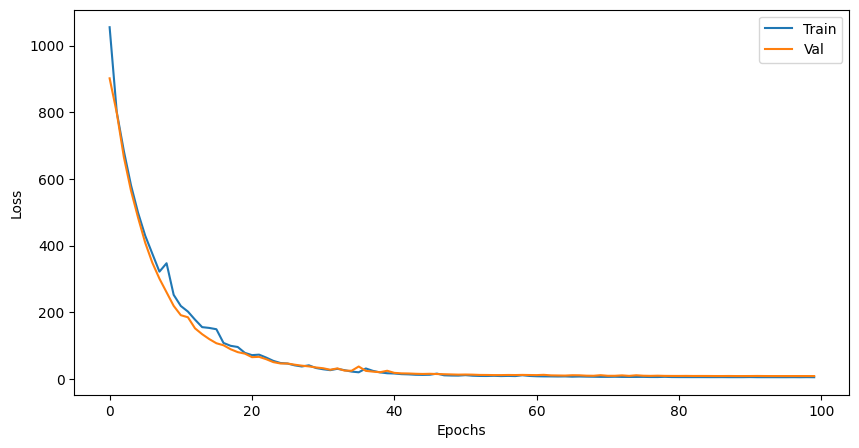

In [388]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [389]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)

print(pred_value, actual_value)

print(f"Test MSE: {mean_squared_error(actual_value, pred_value)}")

tensor([  1.9349,   1.8626,   1.6376,   2.2967,   2.4641,   3.5535,   6.7264,
         12.6174,  12.4015,  10.2581,   8.1567,  10.2696,  14.3285,  11.9209,
         16.4716,  19.0878,  12.0268,   5.0882,   3.3692,   5.2850,   3.2805,
          4.5581,   7.8043,   6.2712,   6.6249,   7.4376,   7.0275,   5.3398,
          4.7067,   6.2905,   8.1701,   7.0765,   8.7311,  10.4658,  11.5080,
         14.7729,  19.0481,  11.6172,  18.7302,  22.7188,  20.4899,  20.9945,
         29.1596,  34.9135,  32.8878,  20.6759,  20.8233,  10.9444,   9.6176,
          7.8089,   7.7508,   8.4286,  12.2451,  13.1673,  15.5767,  15.7473,
         12.0196,   8.8120,  10.4226,  13.9535,  19.5590,  17.3990,  13.2441,
         14.3640,  13.2685,  14.0093,  11.8265,  12.7399,  12.1833,  12.0172,
         12.1573,  13.9960,  14.1010,  15.1572,  15.4148,  18.0427,  18.5233,
         18.5846,  17.8228,  19.4757,  23.0292,  21.8476,  23.2710,  28.5384,
         30.7859,  34.5753,  47.4033,  64.2264,  77.6793, 106.78

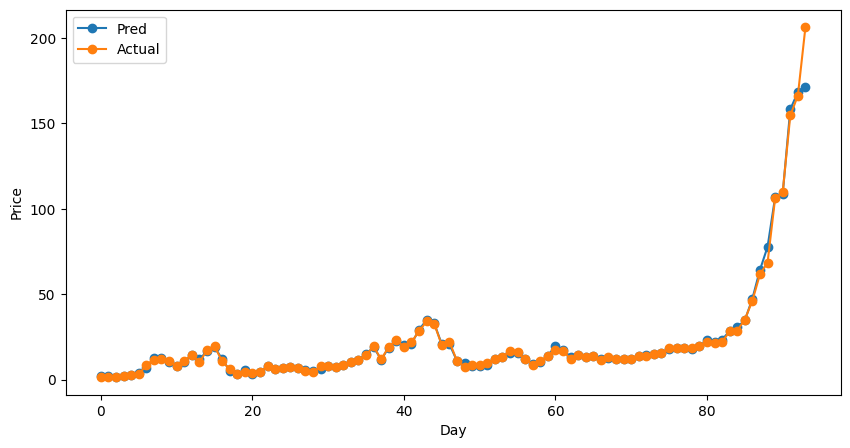

In [390]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:], marker='o')
plt.plot(actual_value[:], marker='o')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()